# How to apply a custom perturbation to a given cross section

In [1]:
import os

import numpy as np
import pandas as pd

In [2]:
import sandy

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In this notebook we apply a constant relative perturbation, say 5%, to an energy-dependent cross section.
The perturbation is applied over an energy bin of choice, e.g. between 10 eV and 100 eV.

As an example we use the JEFF-3.3 evaluation for Pu-239  downloaded from the [OECD/NEA website](https://www.oecd-nea.org/dbdata/jeff/jeff33/index.html) and processed with NJOY-2016 into PENDF format using the following input file.

```
moder
20 -21 /
reconr
-21 -22 /
'sandy runs njoy'/
9437 0 0 /
0.001 0. /
0/
broadr
-21 -22 -23 /
9437 1 0 0 0. /
0.001 /
900.0 /
0 /
thermr
0 -23 -24 /
0 9437 20 1 1 0 0 1 221 0 /
900.0 /
0.001 0.1 /
moder
-24 30 /
```

The PENDF file in output `"tape30"` contains pointwise cross section for Pu-239 processed at 900 K.

### Read the file with sandy

A copy of the processed file is stored locally on this repository. 

In [4]:
folder = "notebook_perturb_pu9_wims_grid"
filename = "tape30"
file = os.path.join(os.getcwd(), folder, filename)

Let's read the file with sandy and extract the cross sections.
In the process, `sandy` spits out a lot of warning saying the duplicate energy points are present... 

In [5]:
tape = sandy.Endf6.from_file(file)
xs = sandy.Xs.from_endf6(tape)

Now, we apply perturbations according to the WIMS-69 energy grid, available on the [Serpent Wiki](http://serpent.vtt.fi/mediawiki/index.php/EPRI-CPM_69_group_structure).
Still, any other energy grids would work just fine.

In [6]:
egrid = sandy.energy_grids.WIMS69
egrid

array([1.0000e-05, 5.0000e-03, 1.0000e-02, 1.5000e-02, 2.0000e-02,
       2.5000e-02, 3.0000e-02, 3.5000e-02, 4.2000e-02, 5.0000e-02,
       5.8000e-02, 6.7000e-02, 8.0000e-02, 1.0000e-01, 1.4000e-01,
       1.8000e-01, 2.2000e-01, 2.5000e-01, 2.8000e-01, 3.0000e-01,
       3.2000e-01, 3.5000e-01, 4.0000e-01, 5.0000e-01, 6.2500e-01,
       7.8000e-01, 8.5000e-01, 9.1000e-01, 9.5000e-01, 9.7200e-01,
       9.9600e-01, 1.0200e+00, 1.0450e+00, 1.0710e+00, 1.0970e+00,
       1.1230e+00, 1.1500e+00, 1.3000e+00, 1.5000e+00, 2.1000e+00,
       2.6000e+00, 3.3000e+00, 4.0000e+00, 9.8770e+00, 1.5968e+01,
       2.7700e+01, 4.8052e+01, 7.5501e+01, 1.4873e+02, 3.6726e+02,
       9.0690e+02, 1.4251e+03, 2.2395e+03, 3.5191e+03, 5.5300e+03,
       9.1180e+03, 1.5030e+04, 2.4780e+04, 4.0850e+04, 6.7340e+04,
       1.1100e+05, 1.8300e+05, 3.0250e+05, 5.0000e+05, 8.2100e+05,
       1.3530e+06, 2.2310e+06, 3.6790e+06, 6.0655e+06, 1.0000e+07])

The energy grid was converted in eV to be consistent with the cross section data.

### Use a `sandy.Pert` object

SANDY uses a dedicated class to store (relative) perturbation coefficients.

In [7]:
sandy.Pert([1, 1.05], index=[10, 100])

ENERGY
(0.0, 10.0]     1.00000e+00
(10.0, 100.0]   1.05000e+00
dtype: float64

In this example the `Pert` instance defines a multiplicative perturbation factor 1 (0%) for all xs values between 0 and 10 eV, and 1.05 (5%) for all xs between 10 and 100 eV.

### Apply perturbations to cross sections

Below we apply perturbations to the fission cross section (MT=18) of Pu-239 (MAT=9437).
For each energy bin in the WIMS grid, we increase all xs points in that energy range by 30%.
The process is repreated iteratively and 69 perturbed xs objects are created.

In [8]:
mat = 9437
mt = 18
pert_coeff = 30 / 100  # large perturbationfor better visualization

In [9]:
perturbed_xs = []
for i in range(1, egrid.size):
    e_start = egrid[i - 1]
    e_stop = egrid[i]
    index = egrid[i - 1: i + 1]
    pert = sandy.Pert([1, 1 + pert_coeff], index=index)
    print(f"perturbed xs in energy bin #{i} [{e_start:.5e}, {e_stop:.5e}]")
    xspert = xs.custom_perturbation(mat, mt, pert)
    perturbed_xs.append(xspert)

perturbed xs in energy bin #1 [1.00000e-05, 5.00000e-03]
perturbed xs in energy bin #2 [5.00000e-03, 1.00000e-02]
perturbed xs in energy bin #3 [1.00000e-02, 1.50000e-02]
perturbed xs in energy bin #4 [1.50000e-02, 2.00000e-02]
perturbed xs in energy bin #5 [2.00000e-02, 2.50000e-02]
perturbed xs in energy bin #6 [2.50000e-02, 3.00000e-02]
perturbed xs in energy bin #7 [3.00000e-02, 3.50000e-02]
perturbed xs in energy bin #8 [3.50000e-02, 4.20000e-02]
perturbed xs in energy bin #9 [4.20000e-02, 5.00000e-02]
perturbed xs in energy bin #10 [5.00000e-02, 5.80000e-02]
perturbed xs in energy bin #11 [5.80000e-02, 6.70000e-02]
perturbed xs in energy bin #12 [6.70000e-02, 8.00000e-02]
perturbed xs in energy bin #13 [8.00000e-02, 1.00000e-01]
perturbed xs in energy bin #14 [1.00000e-01, 1.40000e-01]
perturbed xs in energy bin #15 [1.40000e-01, 1.80000e-01]
perturbed xs in energy bin #16 [1.80000e-01, 2.20000e-01]
perturbed xs in energy bin #17 [2.20000e-01, 2.50000e-01]
perturbed xs in energy 

### Plot the results

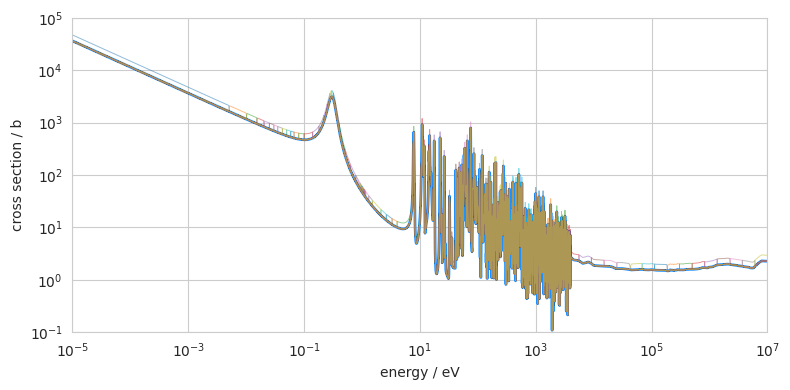

In [10]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax = xs.data[(mat,mt)].plot(logx=True, logy=True, color="dodgerblue", linewidth=2, ax=ax)
for xspert in perturbed_xs:
    ax = xspert.data[(mat,mt)].plot(logx=True, logy=True, alpha=0.5, linewidth=0.7, ax=ax)

ax.set_ylabel("cross section / b")
ax.set_xlabel("energy / eV")
ax.set_xlim([1e-5, 1e7])
ax.set_ylim([1e-1, 1e5])
fig.tight_layout();

### Write perturbed xs to file 

Finally, we can write each perturb cross section into a copy of the original PENDF file for further use.

In [11]:
ipert = 0
tape_pert = perturbed_xs[ipert].to_endf6(tape)
text = tape_pert.to_string()

pert_file = os.path.join(os.getcwd(), folder, f"copy_pert{ipert}.pendf")
with open(pert_file, "w") as f:
    f.write(text)